*Supporting textbook chapters for week 4: 6.1, 6.2, 6.3*

**Lecture 4, topics:**
* Solving linear systems
* Roots of nonlinear equations
* Minima: golden ratio search

# Solving linear systems

## Gaussian elimination

* In linear algebra courses, you learn to solve linear systems of the form
$$A x = v$$
using Gaussian elimination.
* This works pretty well in many cases. Let's do an example based on Newman's `gausselim.py`, for
$$A =
\begin{bmatrix}
6 & 5 \\
4 & 2
\end{bmatrix}, \qquad v = \binom{2}{1}$$

In [ ]:
import numpy as np
import gausselim_as_func as ge

A1 = np.array([[6, 5], [4, 3]], float)  
V1 = np.array([2, 1], float)

ge.gausselim(A1, V1)

Refresher on Gaussian elimination (how `gausselim` works): the previous equation was
$$6x + 5y = 2,$$
$$4x + 3y = 1$$
1. Divide 1st line by 1st (top-left) coefficient:
    $$x + 5y/6 = 1/3,$$
    $$4x + 3y = 1$$

2. $4\times \text{1st eqn} - \text{2nd eqn} = \text{new 2nd eqn}$:
    $$x + 5y/6 = 1/3,$$
    $$0x + y/3 = 1/3$$
    More eqns $\Rightarrow$ cancel all 1st coefficents of each line similarly.

3. (if more eqns: repeat from 2nd line to eliminate all 2nd coefficients below, and so on...)

4. (or 3.) Back-substitute: $y=1 \Rightarrow x + 5/6 = 1/3 \Rightarrow x = -1/2$.

In [ ]:
# %load gausselim_as_func
from numpy import array, empty


def gausselim(A, v):

    N = len(v)

    # Gaussian elimination
    for m in range(N):

        # Divide by the diagonal element
        div = A[m, m]
        A[m, :] /= div
        v[m] /= div

        # Now subtract from the lower rows
        for i in range(m+1, N):
            mult = A[i, m]
            A[i, :] -= mult*A[m, :]
            v[i] -= mult*v[m]

    # Backsubstitution
    x = empty(N, float)
    for m in range(N-1, -1, -1):
        x[m] = v[m]
        for i in range(m+1, N):
            x[m] -= A[m, i]*x[i]

    print(x)


## When Gaussian elimination breaks down

The example below is a valid system but the original code will "break".
$$A =
\begin{bmatrix}
10^{-20} & 1 \\
1 & 1
\end{bmatrix}, \qquad v = \binom{1}{0}.$$
In theory, $\displaystyle x \approx \binom{-1}{1}$. But according to `gausselim`:

In [ ]:
A2 = np.array([[1e-20, 1], [1, 1]], float)  # I imported np earlier
V2 = np.array([1, 0], float)

ge.gausselim(A2, V2)

Don't divide by (close to) zero!
* Had the top-left number actually been zero, Python would have thrown a `ZeroDivisionError`,
* with $10^{-20}<$ machine precision, no tripwire from Python, but rounding errors.

In [ ]:
print("1/1e-20 =", 1/1e-20)  # possible because smaller than the biggest number representable
print("1/0", 1/0.)  # that on the other hand is too obvious

As of two years ago, the following gave the right answer, but it now gives the same, wrong result.

In [ ]:
np.linalg.solve(A2, V2)

SciPy does not do better, but at least it does so in a useful way.

In [ ]:
import scipy as sp
sp.linalg.solve(A2, V2)

Not the topic of this lecture, but always be careful of the evolution of the packages!

**For this lab, it is possible that your results will differ, depending on the version of Python, NumPy, or both. Note that I cannot precisely know how, so, make sure your results make sense.**

## Partial pivoting: 

* Eliminates the issue of dividing by zero if diagonal entries become zero (or very close to zero)

**Algorithm outline:**
1. At $m^\text{th}$ row, check to see which of the rows below has the largest mth element (absolute value)
* Swap this row with the current $m^\text{th}$ value
* Proceed with Gaussian elimination 

In [ ]:
A3 = np.array([[1, 1], [1e-20, 1]], float)  # swapped rows
V3 = np.array([0,1], float)  # need to sap this one too

ge.gausselim(A3, V3)

## LU Decomposition

### Motivation

![Fig. 9: the symmetric normal mode, in the case $m_A = m_B$.](pendulum_asyn.gif)

Take two pendulums, $A$ and $B$, of identical masses and lengths $m$ and $l$, respectively, and coupled by spring of stiffness $k$.
Suppose that each is driven differently, as in
$$ m\ddot x_A + \frac{mg}{l}x_A + k(x_A - x_B) = f_A\cos(\omega_1 t),$$
$$ m\ddot x_B + \frac{mg}{l}x_B -k(x_A - x_B) = f_B\cos(\omega_2 t),$$

* Can write these equations as $A x = f$.
* $A$ is always the same (depends on properties of pendulums and spring),
* but $f$ could change.

The steps in the Gaussian elimination will always be the same: only need to do it once, then store.

Gaussian elimination on a matrix $A$ can be written as a series of matrix multiplications $U = L_nL_{n-1}\cdots L_0A$, where $U$ is upper triangular (i.e., result of Gaussian elimination).

$$L^{-1} = L_n L_{n-1} \cdots L_0 \Rightarrow\ Ax =  LUx = F$$

The decomposition
$$\boxed{LU = A}$$
is called the "LU decomposition" of the matrix $A$.

### How to use LU in practice

* Suppose you know $L$, $U$ from $A$.
* Then, $$Ax=F \Leftrightarrow Ux=L^{-1}F.$$
* Break down into **two triangular-matrix problems, $Ux=y$ and $Ly = f$**.
* Triangular $\Rightarrow$ back-substitution (pizza cake!)
* This method is used by `numpy.linalg.solve`
* `scipy.linalg.lu_solve(scipy.linalg.lu_factor(A), f)` is equivalent to `numpy.linalg.solve(A, f)`, but intermediate steps give access to the decomposition and allow storage.

### Issues with LU Decomposition

LU Decomposition fails when $A$ is close to singular, duue to rounding error again.
E.g.,
$$A = 
\begin{bmatrix}
    1 & 2 \\ 2 & 4
\end{bmatrix}$$
is singular, we can't have
$$A\begin{bmatrix}
    x_1 \\ x_2
\end{bmatrix} = \begin{bmatrix}
    3 \\ 5
\end{bmatrix},$$
i.e., we can't have $x_1 + 2x_2 = 3$ and $5/2$ at the same time, or any other solution (even a compatible RHS leads to an undetermined coefficient).

So, LU won't find a solution when there is none: not really a drawback.
But what about 
$$A = 
\begin{bmatrix}
    1 & 2 \\ 2 & 4+\delta
\end{bmatrix},$$
with $\delta$ very small compared to other coefficients? LU won't work if smaller than machine precision.

In [ ]:
A = np.array([[1, 2], [2, 4+1e-16]], float)
v = np.array([3, 6], float)
np.linalg.solve(A, v)  # returns error

## QR decomposition

For eigensystems: i.e., looking for $\lambda$'s and $v$'s such that

$Av = \lambda v$, with
* $v$: eigenvector
* $\lambda$ eivengalue

or looking for $\Lambda$ and $V$ such that $AV = \Lambda V$, with
* $V$: orthonormal matrix of eigenvectors
* $\Lambda$: diagonal matrix of eigenvalues

If $A$ is square and either symmetric-real or Hermitian (complex), we can solve this problem with a QR decomposition.

### QR algorithm

* Use Gram-Schmidt orthogonalization on columns of $A$ $\Rightarrow$ matrix of orthonormal basis of column vectors $Q$.
* Denote QR decomposition of $A$ as $A = QR$, where $R$ is upper-triangular (assume we know how to decompose)
* $Q$ orthonormal $\Rightarrow\ Q^TQ=I\ \Rightarrow\ R = Q^TA$.

Iterate:

\begin{align*}
$A_1$ & = RQ = Q^TAQ$ & Define  $A_1$ \\
$A_1 &= Q_1R_1 &\text{QR decomposition of } A_1$ \\
$A_2 &= R_1Q_1 = Q_1^TQ^TAQQ_1 &\text{Define } A_2$\\
A_2&=Q_2R_2 &\text{QR decomposition of } A_2
\end{align*}

... and so on.

* Eventually, "it can be proven" that this iteration converges to a (near-)diagonal output $A_k = (Q_k^T\cdots Q_1^TQ^T)A(QQ_1\cdots Q_k)$ 
* diagonal entries of $A_k$ (there are no non-diagonal entries) are the eigenvalues. Let $A_k=D$.
* The eigenvectors are the columns of $V=QQ_1\cdots Q_k$

$$\Rightarrow\ A_k = D = V^TAV\ \Rightarrow\ \boxed{VD = AV}$$

`numpy.linalg` implements the QR algorithm in the `numpy.linalg.eigh` function

In [ ]:
A = np.array([[2,1],[1,2]]) # imported numpy as np earlier

print('A:', A)

eig_vs, V = np.linalg.eigh(A) # calculate eigenvalues & eigenvectors
D = np.diag(eig_vs)  # np.diag constructs a diagonal array

print('eigenvalues: ', eig_vs)
print('eigenvectors: ', V)

# we expect that AV = VD
print('AV:', np.dot(A, V))
print('VD:', np.dot(V, D)) # np.diag constructs a diagonal array

### Be careful!

* `eigh` takes only Hermitian or real symmetric matrices as input
* What happens if we try a different (non-symmetric) matrix?

$$ A =
\begin{bmatrix}
2 & 3 \\
1 & 2
\end{bmatrix}$$


In [ ]:
A = np.array([[2,3],[1,2]])
eig_vs, V = np.linalg.eigh(A) # calculate eigenvalues & eigenvectors
D = np.diag(eig_vs)  # np.diag constructs a diagonal array

print('AV:', np.dot(A, V))
print('VD:', np.dot(V, D)) 

With non-symmetric matrix: $AV \neq VD$.

*Frustrating points:*
* *How to QR-decompose?*
* *Proof of convergence?*
* *Where in the proof is it necessary that *A* be symmetric?*

# Finding roots of nonlinear equations

Newman discusses several methods of this: Relaxation, Newton's method, bisection...

Let's review.


## Relaxation

* Solving for $x$ in an equation $x = f(x)$
* Guess an initial value $x_0$ and iterate until the function converges to a fixed point

$$x_1 = f(x_0)$$
$$x_2 = f(x_1)$$
$$\vdots$$

* Caveat: Can only find *stable* fixed points

In [ ]:
a = 0.5

dx = 1

threshold = 1e-10

def f(x):
    return np.tanh(2*x)

a_list = [a]
print(a_list)

while dx > threshold:
    a_list.append(f(a_list[-1]))
    dx = np.abs(a_list[-1]-a_list[-2])

import matplotlib.pyplot as plt

plt.plot(a_list)
print(a_list[-1])
    

## Newton's method

Solving for $x$ in $f(x) = 0$

1. Start with some value $x_1$, calculate tangent $f'(x_1)$
2. Travel along tangent line to intersection with $x$-axis at $x_2$
3. Repeat (calculate tangent $f'(x_2)$, etc.)


Mathematically:

$$x_{n+1} = x_n-\frac{f(x_n)}{f'(x_n)}$$

**Secant method:** If analytic form of $f$ is unknown, calculate $f'(x)$ using numerical difference (usually forward or backward, to avoid re-computing yet another $f(x_k)$).


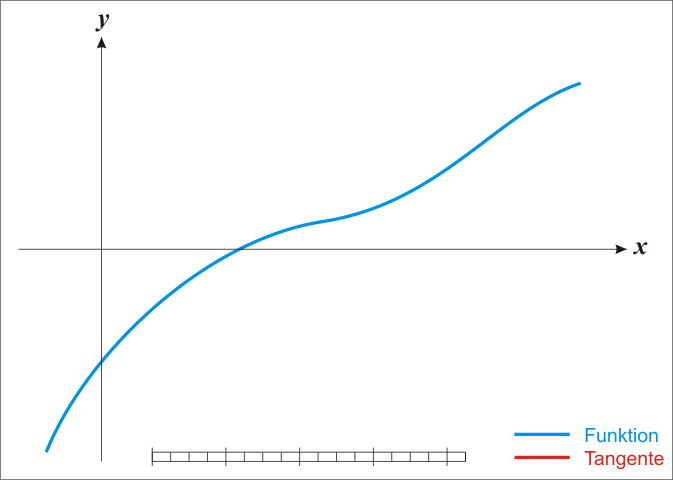

**Pro:**
* Much faster than relaxation

**Cons:**
* Need to know $f'$ (although this issue is addressed by the secant method)
* Doesn't always converge
    * need to have good initial guess (like relaxation),
    * may follow slope in wrong direction,
    * small $f'$ gives $x_{n+1}$ much farther away,
    * sometimes, it just does not converge. Period. (e.g., fractals)

## Bisection (or Binary Search)

* Bracket a single root on either side of the zero of the function $(x_1,x_2)$
* Use midpoint $x'$ as subsequent bracket 
* Choose brackets depending on the sign of the value at the midpoint; 
     - For this example, $f(x') < 0$, so the next set of brackets is $(x_1,x')$

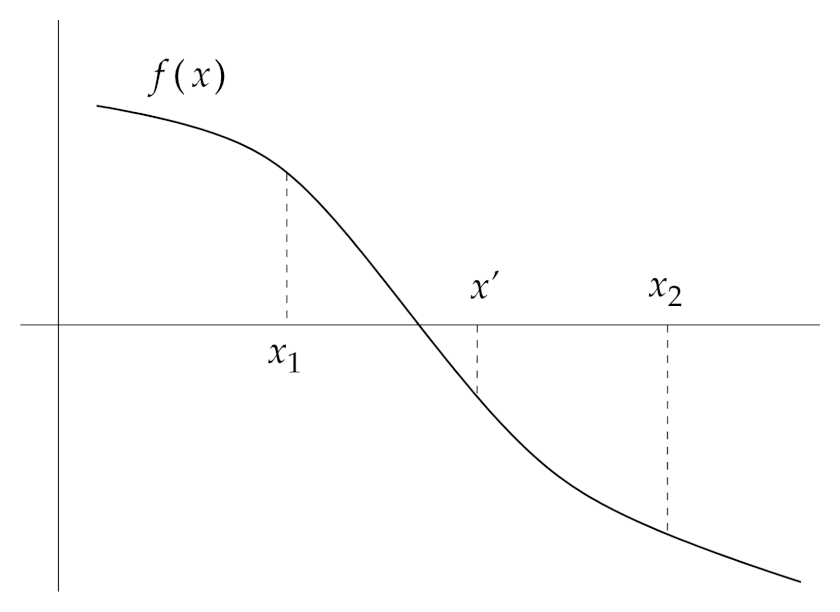

**Pro:**
* Incredibly easy to remember, therefore to implement
* When there's a root, there's a way (no worries about converging towards at least *a* root)

**Cons:**
* Only works with a single bracketed root
* Can't find "double roots" where $f(x)$ does not cross 0 (think $f(x)=x^2$)
* Large sample intervals can "miss" roots
* Slower than Newton

### Convergence characteristics

![](ConvergenceRoots.png)

## Finding minima/maxima

* Many ways to do this

* This week's example: Golden Ratio search

## Golden ratio search

Similar to binary search: find minimum by shrinking intervals

1. Start with 2 points $a,b$ bracketing the interval
2. Choose 2 points $x_1,x_2$ inside the interval
* Check which of $f(x_1)$ and $f(x_2)$ is lower to determine new brackets

Use the golden ratio to determine the most optimal placement of the internal points $x_1, x_2$

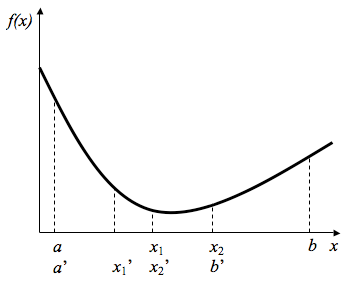

## Golden ratio search: intuition

**[Will expand]**

* Interior points $x_1$, $x_2$ are symmetric about the midpoint of the interval
* With each iteration, we want the new interior points to have the same ratio to the edges


\begin{align*}
\frac{b-a}{x_2-a} &= \frac{b'-a'}{x_2'-a'} & & \frac{A+B}{A}\\
&= \frac{x_2-a}{x_1-a}& & \frac{A}{B}
\end{align*}

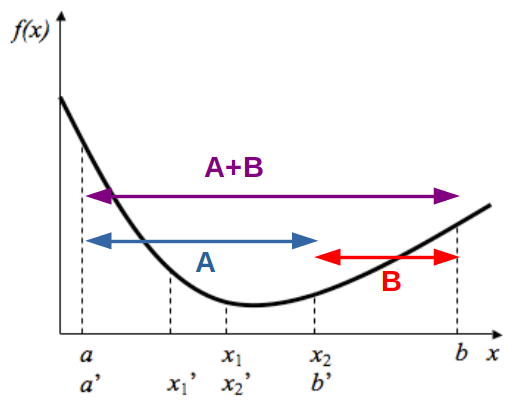